In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

In [3]:
def download(url, max_dim = None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin = url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

In [4]:
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

In [5]:
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

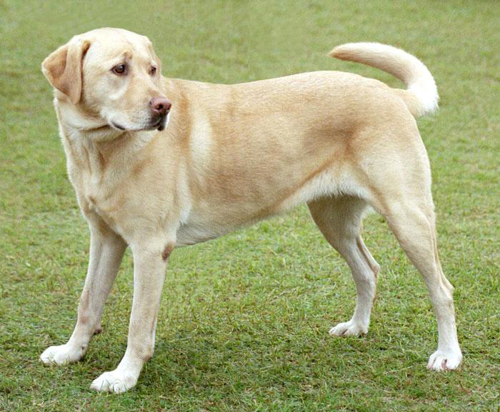

In [6]:
original_img = download(url, max_dim = 500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top= False, weights = 'imagenet')

In [27]:
names = ['mixed1', 'mixed3']
layers = [base_model.get_layer(name).output for name in names]
deep_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

In [28]:
deep_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [29]:
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis = 0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    
    return tf.reduce_sum(losses)

In [30]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape = [None, None, 3], dtype = tf.float32),
            tf.TensorSpec(shape = [], dtype = tf.int32),
            tf.TensorSpec(shape = [], dtype = tf.float32),
        )
    )

    def __call__(self, img, steps, step_size):
        print('Tracing')
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
            
            gradients = tape.gradient(loss, img)

            gradients /= tf.math.reduce_std(gradients) + 1e-8

            img += gradients*step_size
            img = tf.clip_by_value(img, -1 ,1)
        
        return loss, img



In [31]:
deepdream = DeepDream(deep_model)

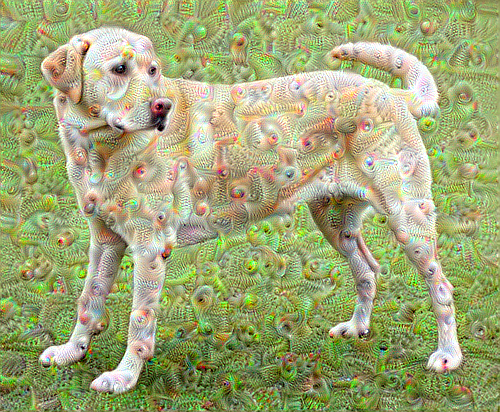

In [34]:
def run_deep_dream_simple(img, step = 100, step_size = 0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = step
    step = 0
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait = True)
        show(deprocess(img))
        print(f'Step {step}, loss {loss}')

    result = deprocess(img)
    display.clear_output(wait= True)
    show(result)

dream_img = run_deep_drea_simple(img = original_img, step = 100, step_size = 0.01)

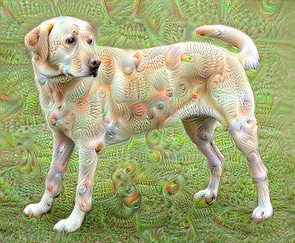

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [35]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, step=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start